# 1.Introduction

In a city of your choice, if someone is looking to open a restaurant, where would you recommend that they open it? Similarly, if a contractor is trying to start their own business, where would you recommend that they setup their office?

## 1.1 Problem discussion

This report would like to select Manhattan to expand this problem. So far we need to select a place to open a restaurant in the manhattan area. Restaurant has many different kinds. It could be a small take out food shop, and it could also be a luxtry sushi place. The different restaurant has different investment and different incomes. If someone want to open a steak house, it is not a good idea to open it in chinatown. Nevertheless, investing a chinsese restaurant at the chinatown might be a very good choise. Even if we do not catagory the restaurant kind, there are also many factors to select a place to open a general restaurant. How detailed the problem could be solved depends on how much data and time we have to approach this probelm.

## 1.2 Map Ploting

We focus on the neighbourhood in the manhattan area. Each neighbourhood represents a possible selection for our restaurant opening place. We need to first plot the neighbourhood distribution of the manhattan area. Implementing the folium to plot the neighborhood in manhattan.

In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import io

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


Then webscraping the postal code information and retrive the location and neighbourhood information in each postal code. We ploted all the neighbourhoods in the great toronto area.

In [8]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [8]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [13]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


In [12]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

## 1.3 Problem definition

The above figure shows the neighbourhood distribution for the great toronto area. The first problem could be definded as "If someone want to open a general restaurant in the manhattan area, which neighbourhood shown above is the best choise for him?"

Then if the data and time is allowed, the deeper investigation could be into a problem that "If someone wants to open a specific restaurant in the manhattan area, and he tells you what kind of restaurant he would like to open and how much money he can invest, which neighbourhood shown above is the best choice for him?"

# 2 Data Selection

## 2.1 Data Source

The data contains the neibourhood's location data and the venue data. The location data is webscreping from wikipedia:https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, the location is from http://cocl.us/Geospatial_data. The venue data is request from the foursquare.

## 2.2 Data Selection

The data contains three levels. The first level is the location of each neighbourhood. The second level is the venues belong to each neighbourhood, and the third level is the properties of each venue.

We will focusing on the venue which belong to the food catagory. If the time is allowed, we will separate the restaurant into detailed catagory to analyze. First, lets look at the first level data.

### 2.2.1 First level data

In [35]:
manhattan_data=manhattan_data.drop('Borough',axis=1)

In [36]:
manhattan_data.head()

,Neighborhood,Latitude,Longitude
0,Marble Hill,40.876551,-73.910660
1,Chinatown,40.715618,-73.994279
2,Washington Heights,40.851903,-73.936900
3,Inwood,40.867684,-73.921210
4,Hamilton Heights,40.823604,-73.949688


### 2.2.1 Second level data

The second level data includes the venues list in the Neighbourhood. Using the exlore endpoint to request the information from foursquare. 

In [160]:
#CLIENT_ID = '5XIMYHOCOR30GGNRYTHQQVJ1UOOQXGLVJBWBS44JN43O4RG4' # your Foursquare ID
#CLIENT_SECRET = 'R1UPQH33UDN5ATR44JJBH2EFIIIT4R4QWFAPKUWTIVNY0TL1' # your Foursquare Secret
#CLIENT_ID = 'MMUAPHRYRZKUCHXSVPCLDUUSJ2OF4WGTLBYEEYBCSRWD4DYE' # your Foursquare ID
#CLIENT_SECRET = '1CSAXXXSKQITIRAMU1IY15WCNSCGB2L4MX2IXNRMANCWWO1T' # your Foursquare Secret
CLIENT_ID = 'KCTUUZK33HMPV1HLU31JGFFTV5JGAMXGUNDZOKUEMHE5PSUX' # your Foursquare ID
CLIENT_SECRET = 'ZE5ODSUWXJ0M42Z5FSJMNBTA1A1GKZUGDBUZGBEJQKTBBBP0' # your Foursquare Secret
VERSION = '20210312' # Foursquare API version
openNow = 0
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KCTUUZK33HMPV1HLU31JGFFTV5JGAMXGUNDZOKUEMHE5PSUX
CLIENT_SECRET:ZE5ODSUWXJ0M42Z5FSJMNBTA1A1GKZUGDBUZGBEJQKTBBBP0


In [38]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = result.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 40.87655077879964, -73.91065965862981.


In [39]:
# type your answer here
LIMIT = 50 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
section = 'food'
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&openNow={}&section={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT,
    openNow,
    section)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=5XIMYHOCOR30GGNRYTHQQVJ1UOOQXGLVJBWBS44JN43O4RG4&client_secret=R1UPQH33UDN5ATR44JJBH2EFIIIT4R4QWFAPKUWTIVNY0TL1&v=20210312&ll=40.87655077879964,-73.91065965862981&radius=500&limit=50&openNow=1&section=food'

In [10]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [127]:
def getNearbyfoodVenues(names, latitudes, longitudes, radius=500):
    LIMIT=500
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        section = 'food'
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&openNow={}&section={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            0,
            section)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']
            ) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                            'id']
    
    return(nearby_venues)

In [128]:
manhattan_food_venues=getNearbyfoodVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [129]:
print(manhattan_food_venues.shape)
manhattan_food_venues.head()

(2803, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,id
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place,4b4429abf964a52037f225e3
1,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner,4b79cc46f964a520c5122fe3
2,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop,4b5357adf964a520319827e3
3,Marble Hill,40.876551,-73.91066,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant,4b9c9c6af964a520b27236e3
4,Marble Hill,40.876551,-73.91066,Subway,40.874667,-73.909586,Sandwich Place,4b4f7b65f964a5205a0827e3


In [135]:
c=pd.DataFrame(manhattan_food_venues['id'].unique())
c.rename(columns={0:'id'},inplace=True)

In [136]:
c

,id
0,4b4429abf964a52037f225e3
1,4b79cc46f964a520c5122fe3
2,4b5357adf964a520319827e3
3,4b9c9c6af964a520b27236e3
4,4b4f7b65f964a5205a0827e3
...,...
2563,5186c69c498ea0e23253df02
2564,4e8c68dfb803540e785aa5f2
2565,59da6a2c0a08ab3b81d58d8d
2566,5b9929ef780eee002c87cd15


In [130]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        openNow = 0
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&openNow={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            1000,
            openNow
        )
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['id']
            ) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                            'id']
    
    return(nearby_venues)

In [131]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [132]:
manhattan_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,id
0,Marble Hill,40.876551,-73.910660,Arturo's,40.874412,-73.910271,Pizza Place,4b4429abf964a52037f225e3
1,Marble Hill,40.876551,-73.910660,Bikram Yoga,40.876844,-73.906204,Yoga Studio,4baf59e8f964a520a6f93be3
2,Marble Hill,40.876551,-73.910660,Tibbett Diner,40.880404,-73.908937,Diner,4b79cc46f964a520c5122fe3
3,Marble Hill,40.876551,-73.910660,Dunkin',40.877136,-73.906666,Donut Shop,4b5357adf964a520319827e3
4,Marble Hill,40.876551,-73.910660,Astral Fitness & Wellness Center,40.876705,-73.906372,Gym,4cf6ae55d3a8a1cd71a9d243
...,...,...,...,...,...,...,...,...
3237,Hudson Yards,40.756658,-74.000111,George's,40.757760,-74.000963,Burger Joint,4e8c68dfb803540e785aa5f2
3238,Hudson Yards,40.756658,-74.000111,Jake's,40.757954,-74.002296,American Restaurant,5b9929ef780eee002c87cd15
3239,Hudson Yards,40.756658,-74.000111,NYPD Mounted Unit,40.759155,-74.004121,Stables,4beede46e8c3c92803479992
3240,Hudson Yards,40.756658,-74.000111,Unlimited Biking,40.759560,-74.003975,Athletics & Sports,578ba323498e37a835430e42


### 2.2.1 Third level data

In [63]:
def getVenueDetails(vid):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
    vid,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
    data1= requests.get(url).json()["response"]
    
    try:
        tier=data1['venue']['price']['tier']
    except:
        tier=0
    try:
        rate=data1['venue']['rating']
    except:
        rate=0
    try:
        tipcount=data1['venue']['stats']['tipCount']
    except:
        tipcount=0
    try:
        likes=data1['venue']['likes']['count']
    except:
        likes=0
    l=len(data1['venue']['categories'])
    catagory=[]
    for i in range(l):
        catagory.append(data1['venue']['categories'][i]['name'])
    detail=[tier,rate,tipcount,likes,l,catagory]
    return detail

In [31]:
df = pd.read_csv('./food.csv')
df=df.drop(['Unnamed: 0'],axis=1)

'4c0150f4716bc9b65b9dbb55'

In [95]:
vid='4c0150f4716bc9b65b9dbb55'
url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
    vid,
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
data1= requests.get(url)

In [96]:
url

'https://api.foursquare.com/v2/venues/4c0150f4716bc9b65b9dbb55?&client_id=5XIMYHOCOR30GGNRYTHQQVJ1UOOQXGLVJBWBS44JN43O4RG4&client_secret=R1UPQH33UDN5ATR44JJBH2EFIIIT4R4QWFAPKUWTIVNY0TL1&v=20210312'

{'meta': {'code': 429,
  'errorType': 'quota_exceeded',
  'errorDetail': 'Quota exceeded',
  'requestId': '60513cbd76b371362aabeeeb'},
 'response': {}}

In [142]:
mht_food_venues1=c[0:490]
mht_food_venues2=c[490:980]
mht_food_venues3=c[980:1470]
mht_food_venues4=c[1470:1960]
mht_food_venues5=c[1960:2450]
mht_food_venues6=c[2450:2568]

In [161]:
d=[]
for id in mht_food_venues6['id']:
    data2=getVenueDetails(id)
    d.append(data2)
dd=pd.DataFrame(d)
dd.columns=['Tier','Rating','TipNumber','Likes','Catagory Number','Catagory']
dd

,Tier,Rating,TipNumber,Likes,Catagory Number,Catagory
0,3,9.1,72,427,1,[Thai Restaurant]
1,2,9.0,274,1222,1,[Japanese Restaurant]
2,2,8.9,315,1156,1,[Donut Shop]
3,1,8.9,20,119,3,"[Café, Bakery, Coffee Shop]"
4,2,8.9,103,460,2,"[Japanese Restaurant, Sushi Restaurant]"
...,...,...,...,...,...,...
113,2,7.0,15,32,1,[Indian Restaurant]
114,1,0.0,0,0,1,[Burger Joint]
115,2,0.0,0,0,1,[BBQ Joint]
116,2,0.0,0,1,1,[American Restaurant]


In [162]:
dd.to_csv('./mht2568.csv')

In [145]:
mht_food_detail1=pd.read_csv('./mht490.csv')
mht_food_detail1.set_index('Unnamed: 0')

,Tier,Rating,TipNumber,Likes,Catagory Number,Catagory
Unnamed: 0,,,,,,
0,1,8.1,17,16,2,"['Pizza Place', 'Italian Restaurant']"
1,1,8.7,20,47,1,['Diner']
2,1,7.7,14,68,2,"['Donut Shop', 'Coffee Shop']"
3,2,7.1,19,42,2,"['Seafood Restaurant', 'American Restaurant']"
4,1,6.6,1,1,2,"['Sandwich Place', 'Fast Food Restaurant']"
...,...,...,...,...,...,...
485,1,7.0,16,12,1,['Restaurant']
486,2,7.0,55,153,2,"['Italian Restaurant', 'Pizza Place']"
487,2,7.4,0,14,1,['Mexican Restaurant']


In [148]:
mht_food_detail2=pd.read_csv('./mht980.csv')
mht_food_detail2['Unnamed: 0']=mht_food_detail2['Unnamed: 0']+490
mht_food_detail2.set_index('Unnamed: 0')

,Tier,Rating,TipNumber,Likes,Catagory Number,Catagory
Unnamed: 0,,,,,,
490,1,6.9,25,33,1,['Pizza Place']
491,1,7.7,27,124,1,['Salad Place']
492,2,7.2,12,15,1,['Asian Restaurant']
493,3,7.3,72,106,1,['Burger Joint']
494,4,7.6,9,16,1,['Italian Restaurant']
...,...,...,...,...,...,...
975,1,7.9,32,140,3,"['Burger Joint', 'American Restaurant', 'Seafo..."
976,1,8.4,12,42,1,['Bakery']
977,1,9.0,86,356,1,['Pizza Place']


In [152]:
mht_food_detail3=pd.read_csv('./mht1470.csv')
mht_food_detail3['Unnamed: 0']=mht_food_detail3['Unnamed: 0']+980
mht_food_detail3.set_index('Unnamed: 0')

,Tier,Rating,TipNumber,Likes,Catagory Number,Catagory
Unnamed: 0,,,,,,
980,1,8.6,20,46,1,['Sandwich Place']
981,2,9.0,27,83,2,"['Sushi Restaurant', 'Cocktail Bar']"
982,3,7.4,153,459,2,"['American Restaurant', 'Café']"
983,2,7.8,42,78,3,"['Deli / Bodega', 'Salad Place', 'Breakfast Sp..."
984,1,8.4,10,38,2,"['Donut Shop', 'Bakery']"
...,...,...,...,...,...,...
1465,2,7.6,3,9,1,['Asian Restaurant']
1466,0,7.6,3,10,3,"['Food Court', 'American Restaurant', 'Event S..."
1467,2,7.4,38,93,2,"['American Restaurant', 'Cocktail Bar']"


In [156]:
mht_food_detail4=pd.read_csv('./mht1960.csv')
mht_food_detail4['Unnamed: 0']=mht_food_detail4['Unnamed: 0']+1470
mht_food_detail4.set_index('Unnamed: 0')

,Tier,Rating,TipNumber,Likes,Catagory Number,Catagory
Unnamed: 0,,,,,,
1470,2,7.3,54,116,3,"['Diner', 'American Restaurant', 'Breakfast Sp..."
1471,2,6.7,1,5,1,['Italian Restaurant']
1472,1,7.1,22,32,1,['Bakery']
1473,2,7.0,4,14,1,['Italian Restaurant']
1474,2,6.8,3,13,1,['Italian Restaurant']
...,...,...,...,...,...,...
1955,2,8.0,12,18,1,['Italian Restaurant']
1956,3,8.5,20,45,2,"['French Restaurant', 'Breakfast Spot']"
1957,1,7.9,8,17,1,['Café']


In [159]:
mht_food_detail5=pd.read_csv('./mht2450.csv')
mht_food_detail5['Unnamed: 0']=mht_food_detail5['Unnamed: 0']+1960
mht_food_detail5.set_index('Unnamed: 0')

,Tier,Rating,TipNumber,Likes,Catagory Number,Catagory
Unnamed: 0,,,,,,
1960,2,7.8,10,48,1,['Mediterranean Restaurant']
1961,2,9.0,111,298,2,"['Pizza Place', 'Italian Restaurant']"
1962,1,8.3,5,6,1,['Food Truck']
1963,2,7.9,37,51,1,['Sushi Restaurant']
1964,2,7.5,65,65,3,"['Café', 'Breakfast Spot', 'Bakery']"
...,...,...,...,...,...,...
2445,1,0.0,0,0,2,"['Deli / Bodega', 'Bagel Shop']"
2446,1,6.9,14,21,1,['Deli / Bodega']
2447,1,6.4,0,2,3,"['Sandwich Place', 'Fast Food Restaurant', 'Re..."


In [163]:
mht_food_detail6=pd.read_csv('./mht2568.csv')
mht_food_detail6['Unnamed: 0']=mht_food_detail6['Unnamed: 0']+2450
mht_food_detail6.set_index('Unnamed: 0')

,Tier,Rating,TipNumber,Likes,Catagory Number,Catagory
Unnamed: 0,,,,,,
2450,3,9.1,72,427,1,['Thai Restaurant']
2451,2,9.0,274,1222,1,['Japanese Restaurant']
2452,2,8.9,315,1156,1,['Donut Shop']
2453,1,8.9,20,119,3,"['Café', 'Bakery', 'Coffee Shop']"
2454,2,8.9,103,460,2,"['Japanese Restaurant', 'Sushi Restaurant']"
...,...,...,...,...,...,...
2563,2,7.0,15,32,1,['Indian Restaurant']
2564,1,0.0,0,0,1,['Burger Joint']
2565,2,0.0,0,0,1,['BBQ Joint']


In [164]:
mht_details=pd.concat([mht_food_detail1,mht_food_detail2,mht_food_detail3,mht_food_detail4,mht_food_detail5,mht_food_detail6],axis=0)
mht_details.set_index('Unnamed: 0')

,Tier,Rating,TipNumber,Likes,Catagory Number,Catagory
Unnamed: 0,,,,,,
0,1,8.1,17,16,2,"['Pizza Place', 'Italian Restaurant']"
1,1,8.7,20,47,1,['Diner']
2,1,7.7,14,68,2,"['Donut Shop', 'Coffee Shop']"
3,2,7.1,19,42,2,"['Seafood Restaurant', 'American Restaurant']"
4,1,6.6,1,1,2,"['Sandwich Place', 'Fast Food Restaurant']"
...,...,...,...,...,...,...
2563,2,7.0,15,32,1,['Indian Restaurant']
2564,1,0.0,0,0,1,['Burger Joint']
2565,2,0.0,0,0,1,['BBQ Joint']


In [168]:
a=mht_details.drop(['Unnamed: 0'], axis=1)
b=c
a['index'] = range(len(a))
b['index'] = range(len(b))
a=a.set_index('index')
b=b.set_index('index')

In [169]:
mht_fd=pd.concat([b,a], axis=1, join='inner')
mht_fd.tail(10)

,id,Tier,Rating,TipNumber,Likes,Catagory Number,Catagory
index,,,,,,,
2558,57e55e46498e04b0dc14dbb0,2,7.7,3,21,1,['Italian Restaurant']
2559,43cdefe7f964a520d72d1fe3,3,7.7,76,110,1,['Steakhouse']
2560,5c98f037db1d81002ca94beb,2,7.7,11,52,1,['Spanish Restaurant']
2561,5c98f0398afbe0002db91491,2,7.6,2,15,1,['Spanish Restaurant']
2562,5d4758417928f300089b87ed,3,7.1,9,27,1,['New American Restaurant']
2563,5186c69c498ea0e23253df02,2,7.0,15,32,1,['Indian Restaurant']
2564,4e8c68dfb803540e785aa5f2,1,0.0,0,0,1,['Burger Joint']
2565,59da6a2c0a08ab3b81d58d8d,2,0.0,0,0,1,['BBQ Joint']
2566,5b9929ef780eee002c87cd15,2,0.0,0,1,1,['American Restaurant']


In [170]:
manhattan_food_venuesp=manhattan_food_venues.join(mht_fd.set_index('id'), on='id')
manhattan_food_venuesp

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,id,Tier,Rating,TipNumber,Likes,Catagory Number,Catagory
0,Marble Hill,40.876551,-73.910660,Arturo's,40.874412,-73.910271,Pizza Place,4b4429abf964a52037f225e3,1,8.1,17,16,2,"['Pizza Place', 'Italian Restaurant']"
1,Marble Hill,40.876551,-73.910660,Tibbett Diner,40.880404,-73.908937,Diner,4b79cc46f964a520c5122fe3,1,8.7,20,47,1,['Diner']
2,Marble Hill,40.876551,-73.910660,Dunkin',40.877136,-73.906666,Donut Shop,4b5357adf964a520319827e3,1,7.7,14,68,2,"['Donut Shop', 'Coffee Shop']"
3,Marble Hill,40.876551,-73.910660,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant,4b9c9c6af964a520b27236e3,2,7.1,19,42,2,"['Seafood Restaurant', 'American Restaurant']"
4,Marble Hill,40.876551,-73.910660,Subway,40.874667,-73.909586,Sandwich Place,4b4f7b65f964a5205a0827e3,1,6.6,1,1,2,"['Sandwich Place', 'Fast Food Restaurant']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,Hudson Yards,40.756658,-74.000111,成都印象 Spicy NYC,40.757291,-73.995281,Chinese Restaurant,4ecef89c8b81b47394d9698e,1,0.0,0,0,1,['Chinese Restaurant']
2799,Hudson Yards,40.756658,-74.000111,breakfast -coffee/muffin guy,40.759088,-73.996016,Breakfast Spot,5194d92d498e5b5c10a9a0f4,1,0.0,0,1,1,['Breakfast Spot']
2800,Hudson Yards,40.756658,-74.000111,Superior Gourmet,40.759133,-73.996060,Deli / Bodega,5c38888a3abcaf002cd3099e,1,0.0,0,1,1,['Deli / Bodega']
2801,Hudson Yards,40.756658,-74.000111,Pier Cafe,40.759625,-74.004162,Café,5243134f11d2daa4bf660257,1,0.0,0,1,1,['Café']


In [171]:
manhattan_food_venuesp.isna().sum()

Neighborhood              0
Neighborhood Latitude     0
Neighborhood Longitude    0
Venue                     0
Venue Latitude            0
Venue Longitude           0
Venue Category            0
id                        0
Tier                      0
Rating                    0
TipNumber                 0
Likes                     0
Catagory Number           0
Catagory                  0
dtype: int64

# 3.Data Analysis

## 3.1 General data vitualization

In [116]:
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of Toronto using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

In [172]:
mht_fd

,id,Tier,Rating,TipNumber,Likes,Catagory Number,Catagory
index,,,,,,,
0,4b4429abf964a52037f225e3,1,8.1,17,16,2,"['Pizza Place', 'Italian Restaurant']"
1,4b79cc46f964a520c5122fe3,1,8.7,20,47,1,['Diner']
2,4b5357adf964a520319827e3,1,7.7,14,68,2,"['Donut Shop', 'Coffee Shop']"
3,4b9c9c6af964a520b27236e3,2,7.1,19,42,2,"['Seafood Restaurant', 'American Restaurant']"
4,4b4f7b65f964a5205a0827e3,1,6.6,1,1,2,"['Sandwich Place', 'Fast Food Restaurant']"
...,...,...,...,...,...,...,...
2563,5186c69c498ea0e23253df02,2,7.0,15,32,1,['Indian Restaurant']
2564,4e8c68dfb803540e785aa5f2,1,0.0,0,0,1,['Burger Joint']
2565,59da6a2c0a08ab3b81d58d8d,2,0.0,0,0,1,['BBQ Joint']


In [183]:
b=manhattan_food_venuesp['Neighborhood'].value_counts()
b=pd.DataFrame(b)
b.reset_index(inplace=True)
b.rename(columns={'Neighborhood':'Restaurant_Numbers'},inplace=True)
b.rename(columns={'index':'Neighborhood'},inplace=True)
manhattan_data.rename(columns={'Neighborhood':'Neighborhood'},inplace=True)

In [184]:
manhattan_data=pd.merge(manhattan_data, b, how='left', on=['Neighborhood'])
manhattan_data.Restaurant_Numbers.fillna(0,inplace=True)

In [185]:
manhattan_data

,Neighborhood,Latitude,Longitude,Restaurant_Numbers
0,Marble Hill,40.876551,-73.910660,14
1,Chinatown,40.715618,-73.994279,100
2,Washington Heights,40.851903,-73.936900,78
3,Inwood,40.867684,-73.921210,51
4,Hamilton Heights,40.823604,-73.949688,60
5,Manhattanville,40.816934,-73.957385,46
6,Central Harlem,40.815976,-73.943211,45
7,East Harlem,40.792249,-73.944182,52
8,Upper East Side,40.775639,-73.960508,74
9,Yorkville,40.775930,-73.947118,86


Let's look at how many restaurants in each neighborhood.

In [381]:
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of Toronto using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
mx=manhattan_data['Restaurant_Numbers'].max()
x = np.arange(mx)
ys = [i + x + (i*x)**2 for i in range(mx)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to map
for lat, lng,  neighborhood,food_nb in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood'],manhattan_data['Restaurant_Numbers']):
    label = '{}, {}, Restaurant Number:{}'.format(neighborhood, borough,food_nb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=food_nb/10,
        popup=label,
        color=rainbow[food_nb-1],
        fill=True,
        fill_color=rainbow[food_nb-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)
map_manhattan


The majority mount of the neighborhoods have 4 restaurants. It is not significant to classify or critisize the neighborhood within this variable.


Lets see another index. The propotion of the food venue in the total venue list.

In [192]:
b=manhattan_venues['Neighborhood'].value_counts()
b=pd.DataFrame(b)
b.reset_index(inplace=True)
b.rename(columns={'Neighborhood':'Venue_Numbers'},inplace=True)
b.rename(columns={'index':'Neighborhood'},inplace=True)
manhattan_data=pd.merge(manhattan_data, b, how='left', on=['Neighborhood'])

In [380]:
manhattan_data

,Neighborhood,Latitude,Longitude,Restaurant_Numbers,Venue_Numbers,Food_Portion,Likes,Tier,Rating,TipNumber,Likes_N,Tier_N,Rating_N,TipNumber_N
0,Marble Hill,40.876551,-73.910660,14,23,0.608696,14.071429,1.357143,4.214286,5.928571,0.436668,0.597860,0.492093,0.361361
1,Chinatown,40.715618,-73.994279,100,100,1.000000,242.750000,1.360000,8.323000,85.130000,0.906982,0.599119,0.971859,0.902331
2,Washington Heights,40.851903,-73.936900,78,87,0.896552,19.653846,1.384615,4.417949,10.230769,0.491847,0.609963,0.515874,0.472141
3,Inwood,40.867684,-73.921210,51,54,0.944444,14.235294,1.392157,5.898039,8.294118,0.438580,0.613285,0.688701,0.429533
4,Hamilton Heights,40.823604,-73.949688,60,64,0.937500,21.333333,1.266667,6.021667,11.100000,0.505388,0.558003,0.703137,0.488698
5,Manhattanville,40.816934,-73.957385,46,46,1.000000,65.695652,1.478261,5.065217,26.739130,0.691137,0.651216,0.591455,0.667204
6,Central Harlem,40.815976,-73.943211,45,46,0.978261,24.000000,1.600000,5.671111,10.688889,0.524840,0.704846,0.662204,0.481035
7,East Harlem,40.792249,-73.944182,52,38,1.000000,20.730769,1.384615,5.811538,11.750000,0.500657,0.609963,0.678601,0.500252
8,Upper East Side,40.775639,-73.960508,74,100,0.740000,80.067568,2.135135,7.116216,31.013514,0.723809,0.940588,0.830945,0.697313
9,Yorkville,40.775930,-73.947118,86,100,0.860000,47.802326,1.744186,6.469767,21.302326,0.638628,0.768364,0.755461,0.621051


In [382]:
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
mx=manhattan_data['Venue_Numbers'].max()
x = np.arange(mx)
ys = [i + x + (i*x)**2 for i in range(mx)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to map
for lat, lng,  neighborhood,vn_nb in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood'],manhattan_data['Venue_Numbers']):
    label = '{}, {}, Venue Number:{}'.format(neighborhood, borough,vn_nb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=vn_nb/10,
        popup=label,
        color=rainbow[vn_nb-1],
        fill=True,
        fill_color=rainbow[vn_nb-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
map_toronto

In [196]:
manhattan_data=pd.concat([manhattan_data,manhattan_data['Restaurant_Numbers']/manhattan_data['Venue_Numbers']],axis=1)
manhattan_data.rename(columns={0:'Food_Portion'},inplace=True)

In [197]:
manhattan_data

,Neighborhood,Latitude,Longitude,Restaurant_Numbers,Venue_Numbers,Food_Portion
0,Marble Hill,40.876551,-73.910660,14,23,0.608696
1,Chinatown,40.715618,-73.994279,100,100,1.000000
2,Washington Heights,40.851903,-73.936900,78,87,0.896552
3,Inwood,40.867684,-73.921210,51,54,0.944444
4,Hamilton Heights,40.823604,-73.949688,60,64,0.937500
5,Manhattanville,40.816934,-73.957385,46,46,1.000000
6,Central Harlem,40.815976,-73.943211,45,46,0.978261
7,East Harlem,40.792249,-73.944182,52,38,1.368421
8,Upper East Side,40.775639,-73.960508,74,100,0.740000
9,Yorkville,40.775930,-73.947118,86,100,0.860000


In [385]:
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of Toronto using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
mx=int((manhattan_data['Food_Portion'].max()*100))
x = np.arange(mx)
ys = [i + x + (i*x)**2 for i in range(mx)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to map
for lat, lng, neighborhood,vn_nb in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood'],manhattan_data['Food_Portion']*100):
    label = '{}, {}, Restaurant Portion:{}'.format(neighborhood, borough,vn_nb/100)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=vn_nb/20,
        popup=label,
        color=rainbow[int(vn_nb)-1],
        fill=True,
        fill_color=rainbow[int(vn_nb)-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)
map_manhattan

Now we consider the place with higher restaurant protion is better to open restaurant.

In [ ]:
b=manhattan_venues['Neighborhood'].value_counts()
b=pd.DataFrame(b)
b.reset_index(inplace=True)
b.rename(columns={'Neighborhood':'Venue_Numbers'},inplace=True)
b.rename(columns={'index':'Neighborhood'},inplace=True)
manhattan_data=pd.merge(manhattan_data, b, how='left', on=['Neighborhood'])

Let's see the average like number and the average price rate for each neighborhood.

In [201]:
manhattan_food_venuesp

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,id,Tier,Rating,TipNumber,Likes,Catagory Number,Catagory
0,Marble Hill,40.876551,-73.910660,Arturo's,40.874412,-73.910271,Pizza Place,4b4429abf964a52037f225e3,1,8.1,17,16,2,"['Pizza Place', 'Italian Restaurant']"
1,Marble Hill,40.876551,-73.910660,Tibbett Diner,40.880404,-73.908937,Diner,4b79cc46f964a520c5122fe3,1,8.7,20,47,1,['Diner']
2,Marble Hill,40.876551,-73.910660,Dunkin',40.877136,-73.906666,Donut Shop,4b5357adf964a520319827e3,1,7.7,14,68,2,"['Donut Shop', 'Coffee Shop']"
3,Marble Hill,40.876551,-73.910660,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant,4b9c9c6af964a520b27236e3,2,7.1,19,42,2,"['Seafood Restaurant', 'American Restaurant']"
4,Marble Hill,40.876551,-73.910660,Subway,40.874667,-73.909586,Sandwich Place,4b4f7b65f964a5205a0827e3,1,6.6,1,1,2,"['Sandwich Place', 'Fast Food Restaurant']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,Hudson Yards,40.756658,-74.000111,成都印象 Spicy NYC,40.757291,-73.995281,Chinese Restaurant,4ecef89c8b81b47394d9698e,1,0.0,0,0,1,['Chinese Restaurant']
2799,Hudson Yards,40.756658,-74.000111,breakfast -coffee/muffin guy,40.759088,-73.996016,Breakfast Spot,5194d92d498e5b5c10a9a0f4,1,0.0,0,1,1,['Breakfast Spot']
2800,Hudson Yards,40.756658,-74.000111,Superior Gourmet,40.759133,-73.996060,Deli / Bodega,5c38888a3abcaf002cd3099e,1,0.0,0,1,1,['Deli / Bodega']
2801,Hudson Yards,40.756658,-74.000111,Pier Cafe,40.759625,-74.004162,Café,5243134f11d2daa4bf660257,1,0.0,0,1,1,['Café']


In [206]:
b=manhattan_food_venuesp.groupby('Neighborhood')['Likes'].mean()
manhattan_data=pd.merge(manhattan_data, b, how='left', on=['Neighborhood'])

In [208]:
b=manhattan_food_venuesp.groupby('Neighborhood')['Tier'].mean()
manhattan_data=pd.merge(manhattan_data, b, how='left', on=['Neighborhood'])

In [209]:
b=manhattan_food_venuesp.groupby('Neighborhood')['Rating'].mean()
manhattan_data=pd.merge(manhattan_data, b, how='left', on=['Neighborhood'])

In [210]:
b=manhattan_food_venuesp.groupby('Neighborhood')['TipNumber'].mean()
manhattan_data=pd.merge(manhattan_data, b, how='left', on=['Neighborhood'])

In [211]:
manhattan_data

,Neighborhood,Latitude,Longitude,Restaurant_Numbers,Venue_Numbers,Food_Portion,Likes,Tier,Rating,TipNumber
0,Marble Hill,40.876551,-73.910660,14,23,0.608696,14.071429,1.357143,4.214286,5.928571
1,Chinatown,40.715618,-73.994279,100,100,1.000000,242.750000,1.360000,8.323000,85.130000
2,Washington Heights,40.851903,-73.936900,78,87,0.896552,19.653846,1.384615,4.417949,10.230769
3,Inwood,40.867684,-73.921210,51,54,0.944444,14.235294,1.392157,5.898039,8.294118
4,Hamilton Heights,40.823604,-73.949688,60,64,0.937500,21.333333,1.266667,6.021667,11.100000
5,Manhattanville,40.816934,-73.957385,46,46,1.000000,65.695652,1.478261,5.065217,26.739130
6,Central Harlem,40.815976,-73.943211,45,46,0.978261,24.000000,1.600000,5.671111,10.688889
7,East Harlem,40.792249,-73.944182,52,38,1.368421,20.730769,1.384615,5.811538,11.750000
8,Upper East Side,40.775639,-73.960508,74,100,0.740000,80.067568,2.135135,7.116216,31.013514
9,Yorkville,40.775930,-73.947118,86,100,0.860000,47.802326,1.744186,6.469767,21.302326


Normalize the indexes

In [239]:
b=pd.DataFrame(np.log(manhattan_data['Likes'])/np.log(manhattan_data['Likes']).max())
b.rename(columns={'Likes':'Likes_N'},inplace=True)
manhattan_data=pd.concat([manhattan_data,b], axis=1, join='inner')

In [241]:
b=pd.DataFrame(manhattan_data['Tier']/manhattan_data['Tier'].max())
b.rename(columns={'Tier':'Tier_N'},inplace=True)
manhattan_data=pd.concat([manhattan_data,b], axis=1, join='inner')

In [244]:
b=pd.DataFrame(manhattan_data['Rating']/manhattan_data['Rating'].max())
b.rename(columns={'Rating':'Rating_N'},inplace=True)
manhattan_data=pd.concat([manhattan_data,b], axis=1, join='inner')

In [245]:
b=pd.DataFrame(np.log(manhattan_data['TipNumber'])/np.log(manhattan_data['TipNumber']).max())
b.rename(columns={'TipNumber':'TipNumber_N'},inplace=True)
manhattan_data=pd.concat([manhattan_data,b], axis=1, join='inner')

In [246]:
manhattan_data

,Neighborhood,Latitude,Longitude,Restaurant_Numbers,Venue_Numbers,Food_Portion,Likes,Tier,Rating,TipNumber,Likes_N,Tier_N,Rating_N,TipNumber_N
0,Marble Hill,40.876551,-73.910660,14,23,0.608696,14.071429,1.357143,4.214286,5.928571,0.436668,0.597860,0.492093,0.361361
1,Chinatown,40.715618,-73.994279,100,100,1.000000,242.750000,1.360000,8.323000,85.130000,0.906982,0.599119,0.971859,0.902331
2,Washington Heights,40.851903,-73.936900,78,87,0.896552,19.653846,1.384615,4.417949,10.230769,0.491847,0.609963,0.515874,0.472141
3,Inwood,40.867684,-73.921210,51,54,0.944444,14.235294,1.392157,5.898039,8.294118,0.438580,0.613285,0.688701,0.429533
4,Hamilton Heights,40.823604,-73.949688,60,64,0.937500,21.333333,1.266667,6.021667,11.100000,0.505388,0.558003,0.703137,0.488698
5,Manhattanville,40.816934,-73.957385,46,46,1.000000,65.695652,1.478261,5.065217,26.739130,0.691137,0.651216,0.591455,0.667204
6,Central Harlem,40.815976,-73.943211,45,46,0.978261,24.000000,1.600000,5.671111,10.688889,0.524840,0.704846,0.662204,0.481035
7,East Harlem,40.792249,-73.944182,52,38,1.368421,20.730769,1.384615,5.811538,11.750000,0.500657,0.609963,0.678601,0.500252
8,Upper East Side,40.775639,-73.960508,74,100,0.740000,80.067568,2.135135,7.116216,31.013514,0.723809,0.940588,0.830945,0.697313
9,Yorkville,40.775930,-73.947118,86,100,0.860000,47.802326,1.744186,6.469767,21.302326,0.638628,0.768364,0.755461,0.621051


Lets see all the normalized parameters. Here is the Plot of the normalized likes.

In [247]:
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of Toronto using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
mx=int((manhattan_data['Likes_N'].max()*100))
x = np.arange(mx)
ys = [i + x + (i*x)**2 for i in range(mx)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to map
for lat, lng, neighborhood,vn_nb in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood'],manhattan_data['Likes_N']*100):
    label = '{}, {}, Restaurant Portion:{}'.format(neighborhood, borough,vn_nb/100)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[int(vn_nb)-1],
        fill=True,
        fill_color=rainbow[int(vn_nb)-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)
map_manhattan

Here is the Plot of the normalized Tiers.

In [248]:
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of Toronto using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
mx=int((manhattan_data['Tier_N'].max()*100))
x = np.arange(mx)
ys = [i + x + (i*x)**2 for i in range(mx)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to map
for lat, lng, neighborhood,vn_nb in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood'],manhattan_data['Tier_N']*100):
    label = '{}, {}, Restaurant Portion:{}'.format(neighborhood, borough,vn_nb/100)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[int(vn_nb)-1],
        fill=True,
        fill_color=rainbow[int(vn_nb)-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)
map_manhattan

Here is the Plot of the normalized Rating.

In [249]:
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of Toronto using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
mx=int((manhattan_data['Rating_N'].max()*100))
x = np.arange(mx)
ys = [i + x + (i*x)**2 for i in range(mx)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to map
for lat, lng, neighborhood,vn_nb in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood'],manhattan_data['Rating_N']*100):
    label = '{}, {}, Restaurant Portion:{}'.format(neighborhood, borough,vn_nb/100)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[int(vn_nb)-1],
        fill=True,
        fill_color=rainbow[int(vn_nb)-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)
map_manhattan

Here is the Plot of the normalized Tip numbers.

In [398]:
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of Toronto using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
mx=int((manhattan_data['TipNumber_N'].max()*100))
x = np.arange(mx)
ys = [i + x + (i*x)**2 for i in range(mx)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to map
for lat, lng, neighborhood,vn_nb in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood'],manhattan_data['TipNumber_N']*100):
    label = '{}, {}, Restaurant Portion:{}'.format(neighborhood, borough,vn_nb/100)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[int(vn_nb)-1],
        fill=True,
        fill_color=rainbow[int(vn_nb)-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)
map_manhattan

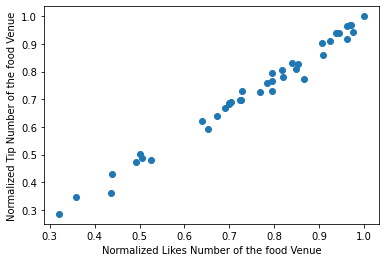

In [256]:
import matplotlib.pyplot as plt
plt.scatter(manhattan_data['Likes_N'], manhattan_data['TipNumber_N'])
plt.xlabel('Normalized Likes Number of the food Venue')
plt.ylabel('Normalized Tip Number of the food Venue')
plt.show()

/Users/wentianwang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/wentianwang/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2036: UserWarning: The marginal plotting function has changed to `histplot`, which does not accept the following argument(s): rug.
  warnings.warn(msg, UserWarning)


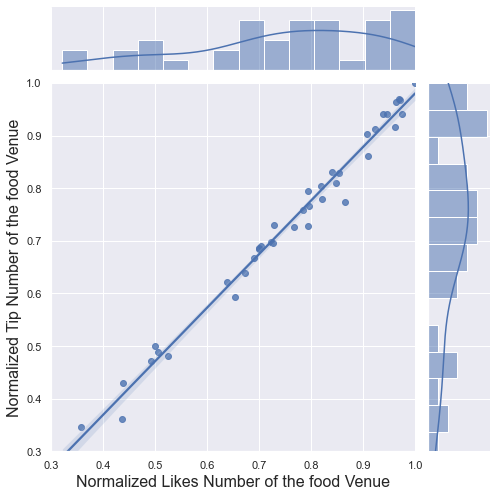

In [277]:
import seaborn as sns
sns.set(style="darkgrid")
g = sns.jointplot('Likes_N', 'TipNumber_N', data=manhattan_data,
                  kind='reg', truncate=True,
                  xlim=(0.3, 1), ylim=(0.3, 1),
                  color='b', height=7,marginal_kws = dict(bins=14, rug =True))
g.set_axis_labels('Normalized Likes Number of the food Venue', 'Normalized Tip Number of the food Venue', fontsize=16)

/Users/wentianwang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/wentianwang/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2036: UserWarning: The marginal plotting function has changed to `histplot`, which does not accept the following argument(s): rug.
  warnings.warn(msg, UserWarning)


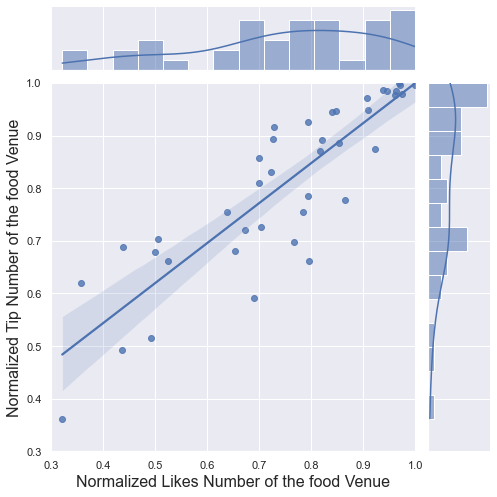

In [279]:
import seaborn as sns
sns.set(style="darkgrid")
g = sns.jointplot('Likes_N', 'Rating_N', data=manhattan_data,
                  kind='reg', truncate=True,
                  xlim=(0.3, 1), ylim=(0.3, 1),
                  color='b', height=7,marginal_kws = dict(bins=14, rug =True))
g.set_axis_labels('Normalized Likes Number of the food Venue', 'Normalized Tip Number of the food Venue', fontsize=16)

/Users/wentianwang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/wentianwang/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:2036: UserWarning: The marginal plotting function has changed to `histplot`, which does not accept the following argument(s): rug.
  warnings.warn(msg, UserWarning)


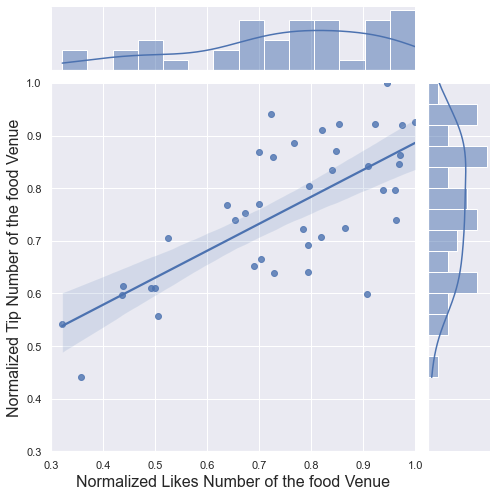

In [280]:
import seaborn as sns
sns.set(style="darkgrid")
g = sns.jointplot('Likes_N', 'Tier_N', data=manhattan_data,
                  kind='reg', truncate=True,
                  xlim=(0.3, 1), ylim=(0.3, 1),
                  color='b', height=7,marginal_kws = dict(bins=14, rug =True))
g.set_axis_labels('Normalized Likes Number of the food Venue', 'Normalized Tip Number of the food Venue', fontsize=16)

In [314]:
similar=pd.DataFrame(manhattan_data,columns=['Venue_Numbers','Restaurant_Numbers','Food_Portion','Rating_N','Tier_N','Likes_N','TipNumber_N'])

/Users/wentianwang/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


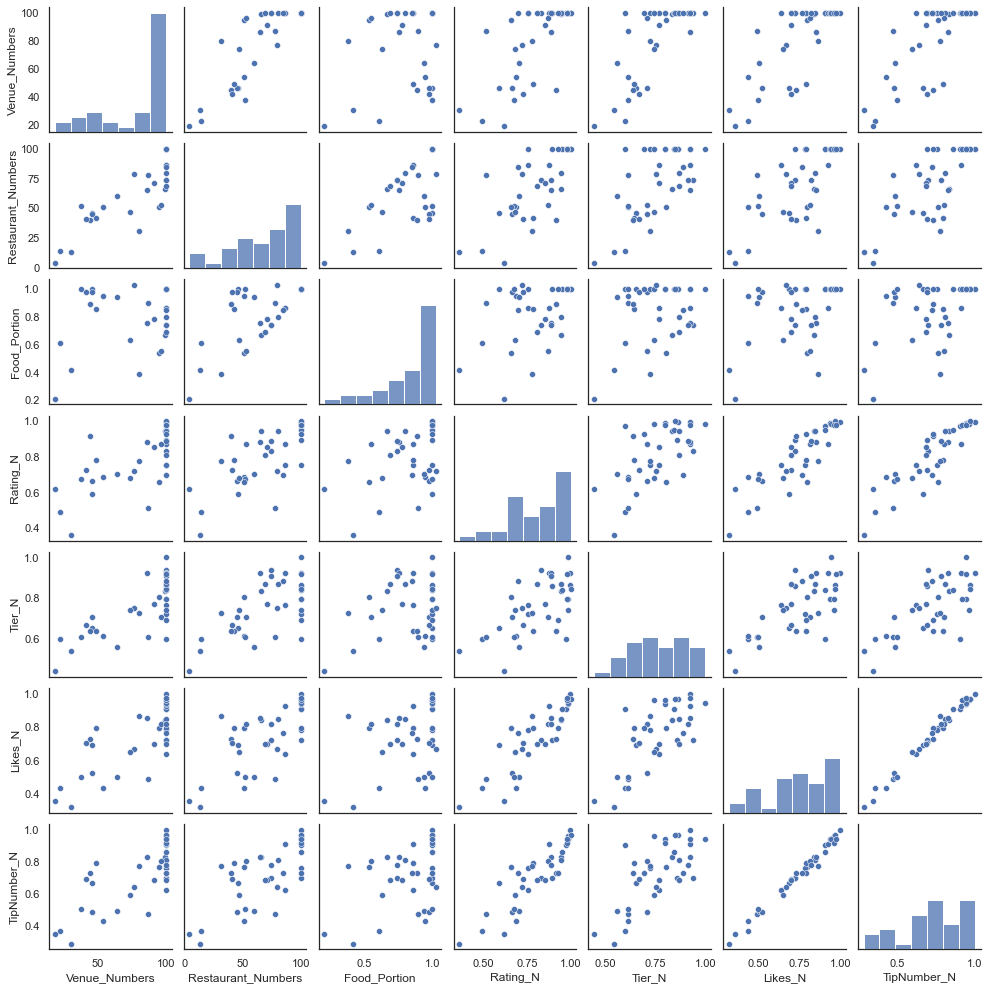

In [319]:
#设置风格
sns.set_style('white')
#读取数据
sns.pairplot(similar,
             kind = 'scatter', #散点图/回归分布图{'scatter', 'reg'})
             diag_kind = 'hist', #直方图/密度图{'hist'， 'kde'}
             palette = 'husl',  #设置调色板
             markers = ['o', 's', 'D'], #设置不同系列的点样式（这里根据参考分类个数）
             size = 2  #图标大小
             )

In [317]:
similar2=pd.DataFrame(manhattan_food_venuesp,columns=['Neighborhood','Tier','Rating','TipNumber','Likes'])

/Users/wentianwang/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


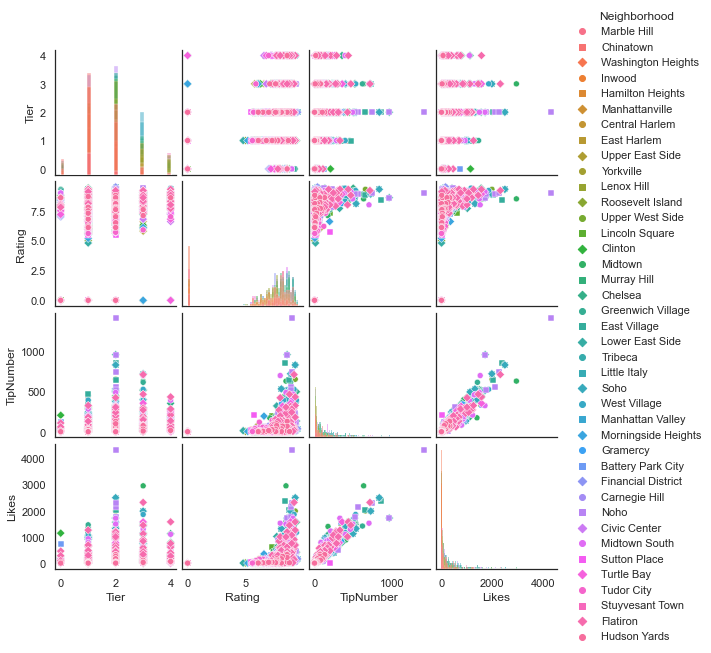

In [324]:
#设置风格
sns.set_style('white')
#读取数据
sns.pairplot(similar2,
             kind = 'scatter', #散点图/回归分布图{'scatter', 'reg'})
             diag_kind = 'hist', #直方图/密度图{'hist'， 'kde'}
             hue = 'Neighborhood',
             palette = 'husl',  #设置调色板
             markers = ['o', 's', 'D','o', 's', 'D','o', 's', 'D','o', 's', 'D','o', 's', 'D','o', 's', 'D','o', 's', 'D','o', 's', 'D','o', 's', 'D','o', 's', 'D','o', 's', 'D','o', 's', 'D','o', 's', 'D','o'], #设置不同系列的点样式（这里根据参考分类个数）
             size = 2  #图标大小
             )

In [326]:
manhattan_data.sort_values('Likes')

,Neighborhood,Latitude,Longitude,Restaurant_Numbers,Venue_Numbers,Food_Portion,Likes,Tier,Rating,TipNumber,Likes_N,Tier_N,Rating_N,TipNumber_N
11,Roosevelt Island,40.762160,-73.949168,13,31,0.419355,7.000000,1.230769,3.100000,4.076923,0.321357,0.542189,0.361980,0.285336
37,Stuyvesant Town,40.731000,-73.974052,4,19,0.210526,8.750000,1.000000,5.300000,5.500000,0.358208,0.440529,0.618870,0.346126
0,Marble Hill,40.876551,-73.910660,14,23,0.608696,14.071429,1.357143,4.214286,5.928571,0.436668,0.597860,0.492093,0.361361
3,Inwood,40.867684,-73.921210,51,54,0.944444,14.235294,1.392157,5.898039,8.294118,0.438580,0.613285,0.688701,0.429533
2,Washington Heights,40.851903,-73.936900,78,87,0.896552,19.653846,1.384615,4.417949,10.230769,0.491847,0.609963,0.515874,0.472141
7,East Harlem,40.792249,-73.944182,52,38,1.000000,20.730769,1.384615,5.811538,11.750000,0.500657,0.609963,0.678601,0.500252
4,Hamilton Heights,40.823604,-73.949688,60,64,0.937500,21.333333,1.266667,6.021667,11.100000,0.505388,0.558003,0.703137,0.488698
6,Central Harlem,40.815976,-73.943211,45,46,0.978261,24.000000,1.600000,5.671111,10.688889,0.524840,0.704846,0.662204,0.481035
9,Yorkville,40.775930,-73.947118,86,100,0.860000,47.802326,1.744186,6.469767,21.302326,0.638628,0.768364,0.755461,0.621051
39,Hudson Yards,40.756658,-74.000111,47,74,0.635135,52.340426,1.680851,5.836170,18.595745,0.653606,0.740463,0.681477,0.593462


# 5.Modelling

we would like to set up an index to criticize the value of setting up a restaurant in a cirtain neighborhood. We have two models to set up the cirtain index.

## 5.1 First model

All the Normalized indexes are used to criticize the restaurant values. The overall index is a linear combination of all the normalized indexes.

Q=(k1 * Food_protion + k2 * Rating_N + k3 * Tier_N + k4 * TipNumber_N + k5 * Likes)/(k1+k2+k3+k4+k5)

The key problem is that how to determine k1-k5. If one of the k value is significantly smaller than all the others, it can be considered as zero. If one of the k value is significantly larger than all the others, all the other k can be considered as zero. So they should be in the same scale. lets say they all range from 1 to 10.

Since the number of likes is highly related to the tip numbers, k4=k5

Q=(k1 * Food_protion + k2 * Rating_N + k3 * Tier_N + k4 * (TipNumber_N + Likes)/2)/(k1+k2+k3+k4)

First lets see what happen if all the k values are equal.

In [328]:
similar3=pd.DataFrame(manhattan_data,columns=['Neighborhood','Food_Portion','Rating_N','Tier_N','Likes_N','TipNumber_N'])

In [350]:
k1=1
k2=1
k3=1
k4=1

In [353]:
b=(k1*similar3['Food_Portion']+k2*similar3['Rating_N']+k3*similar3['Tier_N']+k4*((similar3['Likes_N']+similar3['TipNumber_N'])/2))/(k1+k2+k3+k4)
Qframe=pd.concat([similar3['Neighborhood'],b], axis=1, join='inner')
Qframe=Qframe.rename(columns={0:'Q'})
Qframe.sort_values('Q', ascending=False)

,Neighborhood,Q
24,West Village,0.981814
23,Soho,0.980519
38,Flatiron,0.964482
18,Greenwich Village,0.956989
31,Noho,0.953841
19,East Village,0.931072
33,Midtown South,0.928539
22,Little Italy,0.921789
15,Midtown,0.918968
17,Chelsea,0.893608


The most important index for the restaurant is the numbers of customers. The customer number can be reflected as the numbers of likes. The more people like the restaurant, the more customer will visit the restaurant in the unit time.

In [389]:
k1=1
k2=1
k3=1
k4=3

b=(k1*similar3['Food_Portion']+k2*similar3['Rating_N']+k3*similar3['Tier_N']+k4*((similar3['Likes_N']+similar3['TipNumber_N'])/2))/(k1+k2+k3+k4)
Qframe=pd.concat([similar3['Neighborhood'],b], axis=1, join='inner')
Qframe=Qframe.rename(columns={0:'Q'})
Qframe.sort_values('Q', ascending=False)

,Neighborhood,Q
23,Soho,0.987012
24,West Village,0.968921
38,Flatiron,0.962362
18,Greenwich Village,0.960979
31,Noho,0.959078
22,Little Italy,0.935625
19,East Village,0.933857
33,Midtown South,0.932059
15,Midtown,0.907770
17,Chelsea,0.901647


In [359]:
k1=1
k2=1
k3=2
k4=1

b=(k1*similar3['Food_Portion']+k2*similar3['Rating_N']+k3*similar3['Tier_N']+k4*((similar3['Likes_N']+similar3['TipNumber_N'])/2))/(k1+k2+k3+k4)
Qframe=pd.concat([similar3['Neighborhood'],b], axis=1, join='inner')
Qframe=Qframe.rename(columns={0:'Q'})
Qframe.sort_values('Q', ascending=False)

,Neighborhood,Q
24,West Village,0.985451
23,Soho,0.969437
38,Flatiron,0.955726
18,Greenwich Village,0.938279
31,Noho,0.932236
19,East Village,0.904329
15,Midtown,0.903456
33,Midtown South,0.902302
17,Chelsea,0.899294
22,Little Italy,0.885449


In [363]:
k1=1
k2=2
k3=1
k4=1

b=(k1*similar3['Food_Portion']+k2*similar3['Rating_N']+k3*similar3['Tier_N']+k4*((similar3['Likes_N']+similar3['TipNumber_N'])/2))/(k1+k2+k3+k4)
Qframe=pd.concat([similar3['Neighborhood'],b], axis=1, join='inner')
Qframe=Qframe.rename(columns={0:'Q'})
Qframe.sort_values('Q', ascending=False)

,Neighborhood,Q
23,Soho,0.983808
24,West Village,0.982275
38,Flatiron,0.967405
18,Greenwich Village,0.964704
31,Noho,0.963073
19,East Village,0.942359
33,Midtown South,0.938370
22,Little Italy,0.934185
15,Midtown,0.924992
17,Chelsea,0.889821


In [364]:
k1=2
k2=1
k3=1
k4=1

b=(k1*similar3['Food_Portion']+k2*similar3['Rating_N']+k3*similar3['Tier_N']+k4*((similar3['Likes_N']+similar3['TipNumber_N'])/2))/(k1+k2+k3+k4)
Qframe=pd.concat([similar3['Neighborhood'],b], axis=1, join='inner')
Qframe=Qframe.rename(columns={0:'Q'})
Qframe.sort_values('Q', ascending=False)

,Neighborhood,Q
24,West Village,0.985451
23,Soho,0.984415
38,Flatiron,0.971585
18,Greenwich Village,0.965592
31,Noho,0.963073
19,East Village,0.944858
33,Midtown South,0.942831
22,Little Italy,0.937431
15,Midtown,0.935175
1,Chinatown,0.895127


In [390]:
k1=1
k2=2
k3=3
k4=4

b=(k1*similar3['Food_Portion']+k2*similar3['Rating_N']+k3*similar3['Tier_N']+k4*((similar3['Likes_N']+similar3['TipNumber_N'])/2))/(k1+k2+k3+k4)
Qframe=pd.concat([similar3['Neighborhood'],b], axis=1, join='inner')
Qframe=Qframe.rename(columns={0:'Q'})
Qframe.sort_values('Q', ascending=False)

,Neighborhood,Q
23,Soho,0.976926
24,West Village,0.974078
38,Flatiron,0.955280
18,Greenwich Village,0.945727
31,Noho,0.941565
19,East Village,0.912479
33,Midtown South,0.910387
17,Chelsea,0.904635
22,Little Italy,0.904100
15,Midtown,0.896390


## 5.2 Second model

In [392]:
b=(similar3['Food_Portion']*similar3['Rating_N']*similar3['Tier_N']*((similar3['Likes_N']+similar3['TipNumber_N'])/2))
Qframe=pd.concat([similar3['Neighborhood'],b], axis=1, join='inner')
Qframe=Qframe.rename(columns={0:'Q'})
Qframe.sort_values('Q', ascending=False)

,Neighborhood,Q
24,West Village,0.928157
23,Soho,0.922302
38,Flatiron,0.863710
18,Greenwich Village,0.832922
31,Noho,0.820061
19,East Village,0.739700
33,Midtown South,0.732098
15,Midtown,0.707035
22,Little Italy,0.701354
17,Chelsea,0.636509


In [395]:
plot=pd.merge(manhattan_data, Qframe, how='left', on=['Neighborhood'])

In [397]:
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
# create map of Toronto using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)
# set color scheme for the clusters
mx=int((plot['Q'].max()*100))
x = np.arange(mx)
ys = [i + x + (i*x)**2 for i in range(mx)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
# add markers to map
for lat, lng, neighborhood,vn_nb in zip(plot['Latitude'], plot['Longitude'], plot['Neighborhood'],plot['Q']*100):
    label = '{}, {}, Restaurant Value:{}'.format(neighborhood, borough,vn_nb/100)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=vn_nb/5,
        popup=label,
        color=rainbow[int(vn_nb)-1],
        fill=True,
        fill_color=rainbow[int(vn_nb)-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)
map_manhattan